In [21]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Part 1: Edge Detectors

### 1.1 Sobel Edge Detector

The Sobel edge detection algorithm can be broken down in to three steps:

1. Convolving with Sobel-x filter
2. Convolving with Sobel-y filter
3. Finding gradients

#### 1.1.1 Convolving with Sobel-x filter (5 Points)

We first compute the sobel-x filter multiplying 1D Gaussian filter and x derivative. The equation can be given below:

$$\begin{align}
    s_x &= \begin{bmatrix}
           1 \\
           2 \\
           1
         \end{bmatrix} * \begin{bmatrix} 1 & 0 & -1
         \end{bmatrix}
  \end{align}$$


In [56]:
def conv(image, kernel):

    """ An implementation of convolution filter.
    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.
    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).
    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    for image_h in range(0, Hi):
        for image_w in range(0, Wi):
            out[image_h][image_w] = np.sum(kernel * padded[image_h:kernel.shape[0] + image_h, image_w : kernel.shape[1] + image_w])

    return out

In [57]:
def sobel_x():
    """ Implementation of Sobel-x filter.
    This function follows the sobel-x formula,
    and creates a kernel matrix.
    Args:
    Returns:
        kernel: numpy array of shape (3, 3).
    """

    a = [[1],
         [2],
         [1]]

    b=[[1,0,-1]]

    
    return np.dot(a,b)

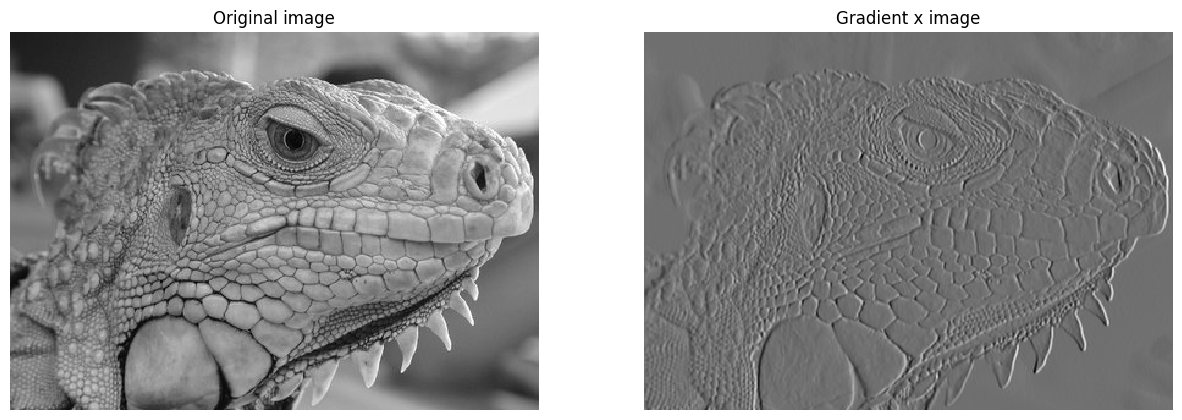

In [58]:
img = io.imread('iguana.png', as_gray=True)

kernel_x = sobel_x()

G_x = conv(img, kernel_x)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(G_x)
plt.title('Gradient x image')
plt.axis('off')

plt.show()

#### 1.1.2 Convolving with Sobel-y filter (5 Points)

We first compute the sobel-y filter multiplying y derivative and 1D Gaussian filter. The equation can be given below:

$$\begin{align}
    s_x &= \begin{bmatrix}
           1 \\
           0 \\
           -1
         \end{bmatrix} * \begin{bmatrix} 1 & 2 & 1
         \end{bmatrix}
  \end{align}$$


In [59]:
def sobel_y():
    """ Implementation of Sobel-y filter.
    This function follows the sobel-y formula,
    and creates a kernel matrix.
    Args:
    Returns:
        kernel: numpy array of shape (3, 3).
    """

    a = [[1],
         [0],
         [-1]]

    b=[[1,2,1]]
    
    return np.dot(a,b)

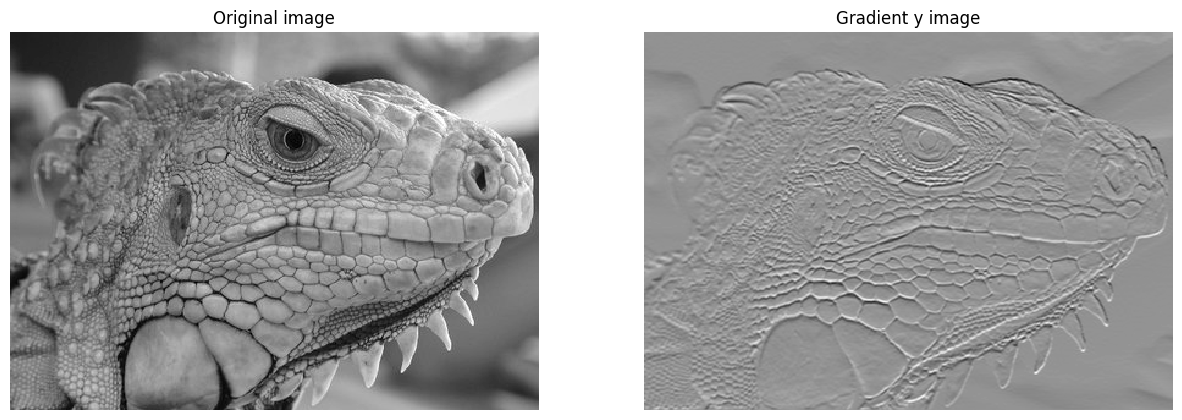

In [60]:
kernel_y = sobel_y()

G_y = conv(img, kernel_y)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(G_y)
plt.title('Gradient y image')
plt.axis('off')

plt.show()

#### 1.1.3 Finding Gradient Magnitude

G_x denotes right direction that increases where G_y denotes down direction that increases. At each point in the image, the resulting gradient can be obtined to give the gradient magnitude and direction below:

$$G = \sqrt{G_{x}^{2} + G_{y}^{2}} \\ \theta = arctan2(\frac{G_y}{G_x})$$

In [27]:
def grad(G_x, G_y):
    """ Returns gradient magnitude and direction of input image sobel gradients.
    Args:
        img: Gradient x and gradient y. Numpy array of shape (H, W).
    Returns:
        G: Magnitude of sobel gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of sobel gradient
            at each pixel in img. Numpy array of shape (H, W).
    """
    G = np.zeros(G_x.shape)
    theta = np.zeros(G_x.shape)

    G = np.sqrt(G_x**2 + G_y**2)
    theta = (np.rad2deg(np.arctan2(G_y, G_x))+180)%360

    return G, theta

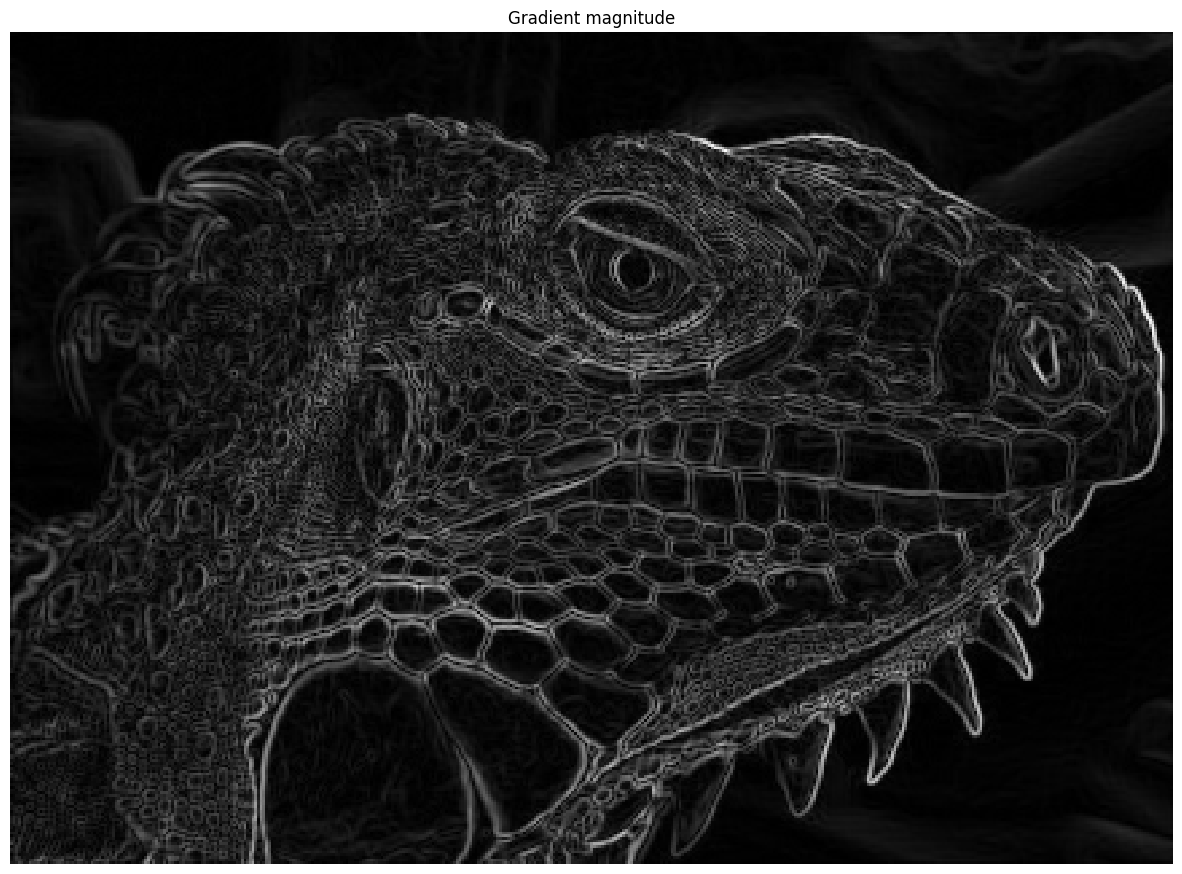

In [28]:
G, theta = grad(conv(img, sobel_x()), conv(img, sobel_y()))

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

#### 1.1.4 Sobel Edge Detector

In [29]:
def sobel(img):
    """ Implement sobel edge detector by calling functions above.
    Args:
        img: binary image of shape (H, W).
    Returns:
        edge: numpy array of shape(H, W).
    """
    H, W = img.shape
    edge = np.zeros((H, W), dtype=bool)

    kernel_x = sobel_x()
    kernel_y = sobel_y()

    G_x = conv(img, kernel_x)
    G_y = conv(img, kernel_y)

    G, theta = grad(G_x, G_y)

    return G

In [ ]:
G=sobel(img)

plt.imshow(G)
plt.title('Final Sobel Edge Detector')
plt.axis('off')
plt.show()

### 1.2 Canny Edge Detector
The Canny edge detection algorithm can be broken down in to five steps:
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

#### 1.2.1 Smoothing
##### Implementation
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

In [30]:
def gaussian_kernel(size, sigma):
    """ Implementation of Gaussian Kernel.
    This function follows the gaussian kernel formula,
    and creates a kernel matrix.
    Args:
        size: int of the size of output matrix.
        sigma: float of sigma to calculate kernel.
    Returns:
        kernel: numpy array of shape (size, size).
    """

    kernel = np.zeros((size, size))

    k = size // 2

    for i in range(size):
        for j in range(size):
            kernel[i, j] = (1.0 / (2.0 * np.pi * sigma**2)) * np.exp((-1.0) * ((i - k)**2 + (j - k)**2) / (2 * (sigma**2)))

    return kernel

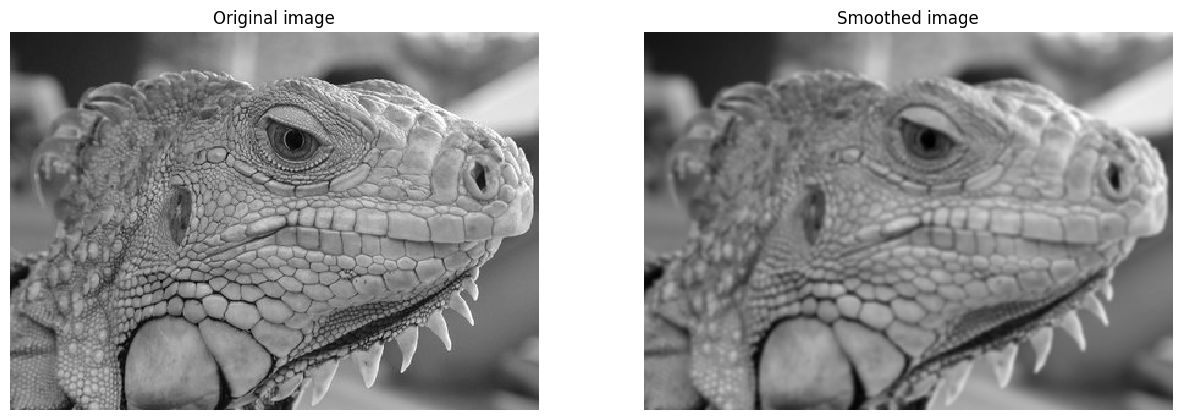

In [31]:
kernel_size = 5
sigma = 1.4

img = io.imread('iguana.png', as_gray=True)

kernel = gaussian_kernel(kernel_size, sigma)

smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

#### 1.2.2 Finding gradients
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

##### Implementation

In [32]:
def partial_x(img):
    """ Computes partial x-derivative of input img.
    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: x-derivative image.
    """

    out = None

    filter_x = np.array([-0.5,0,0.5]).reshape((1, 3))
    out = conv(np.array(img),filter_x)

    return out

In [33]:
def partial_y(img):
    """ Computes partial y-derivative of input img.
    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: y-derivative image.
    """

    out = None

    filter_y = np.array([-0.5, 0, 0.5]).reshape((3, 1))
    out = conv(np.array(img), filter_y)

    return out

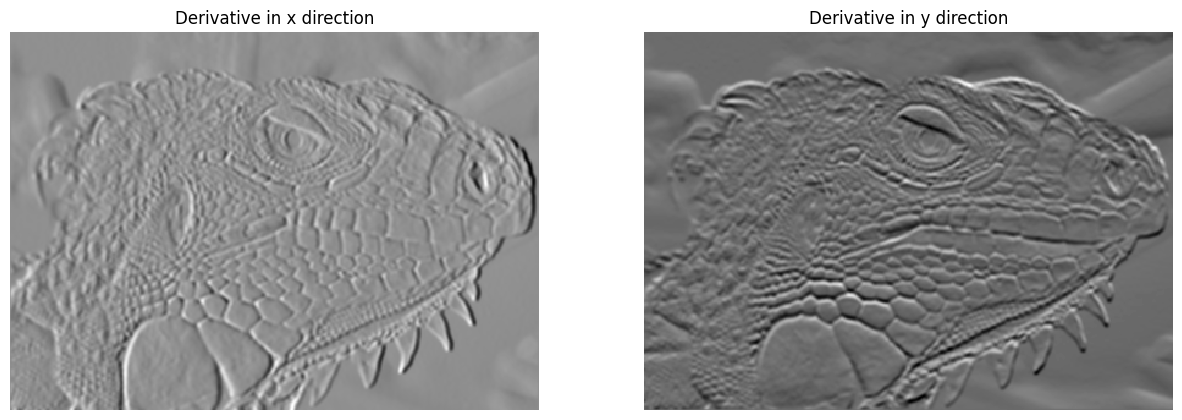

In [34]:
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

##### Implementation 
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan2\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

In [41]:
def gradient(img):
    """ Returns gradient magnitude and direction of input img.
    Args:
        img: Grayscale image. Numpy array of shape (H, W).
    Returns:
        G: Magnitude of gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of gradient
            at each pixel in img. Numpy array of shape (H, W).
    """
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    G = np.sqrt(partial_x(img)**2 + partial_y(img)**2)
    theta = (np.rad2deg(np.arctan2(partial_y(img), partial_x(img)))+180)%360

    return G, theta

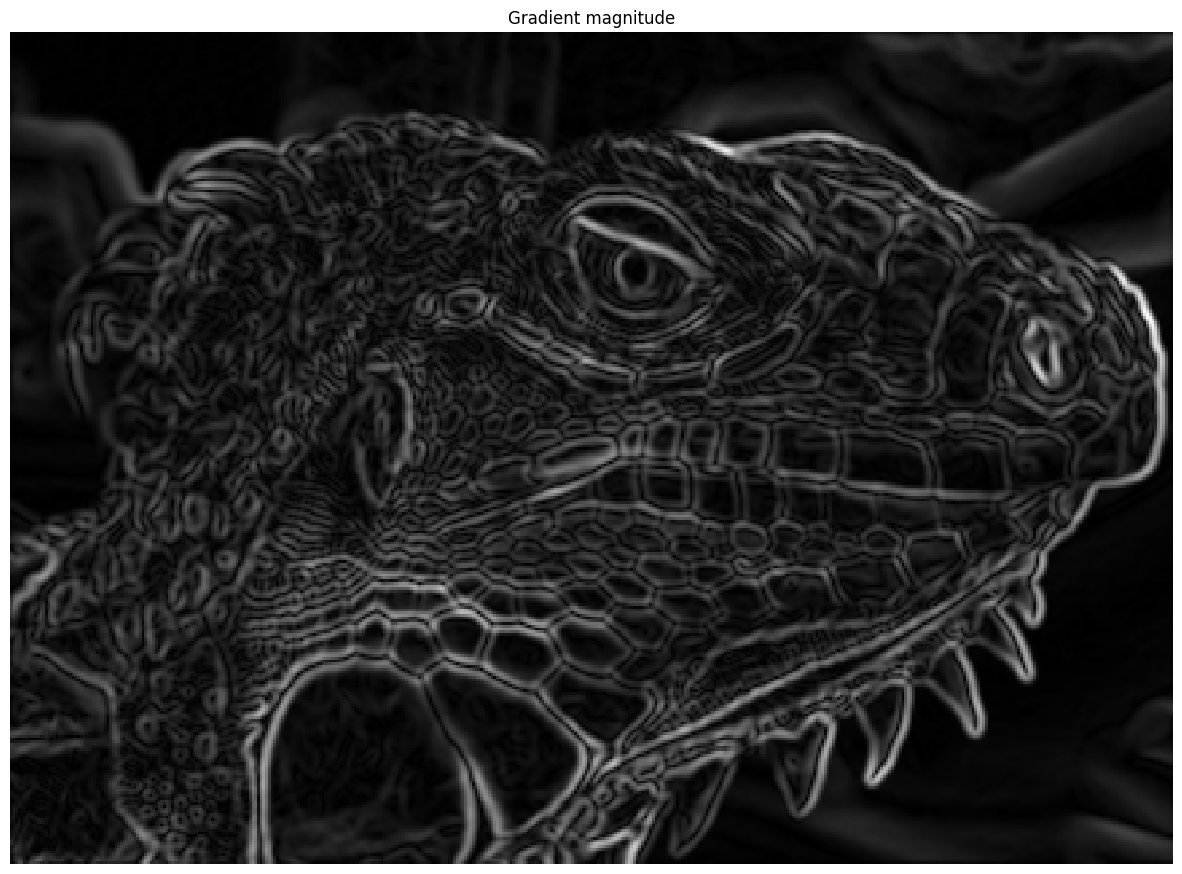

In [42]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

#### 1.2.3 Non-maximum suppression
You should be able to note that the edges extracted from the gradient of the smoothed image is quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient direction. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

In [43]:
def non_maximum_suppression(G, theta):
    """ Performs non-maximum suppression.
    This function performs non-maximum suppression along the direction
    of gradient (theta) on the gradient magnitude image (G).
    Args:
        G: gradient magnitude image with shape of (H, W).
        theta: direction of gradients with shape of (H, W).
    Returns:
        out: non-maxima suppressed image.
    """
    H, W = G.shape
    out = np.zeros((H, W))

    theta = np.floor((theta + 22.5) / 45) * 45
    theta = (theta % 360.0).astype(np.int32)


    for i in range(1, H-1):
        for j in range(1,W-1):
            current_angle = theta[i,j]
            if current_angle == 0 or current_angle == 180:
                neighbors = [G[i, j-1], G[i, j+1]]
            elif current_angle == 45 or current_angle == 225:
                neighbors = [G[i-1, j-1], G[i+1, j+1]]
            elif current_angle == 90 or current_angle == 270:
                neighbors = [G[i-1, j], G[i+1, j]]
            elif current_angle == 135 or current_angle == 315:
                neighbors = [G[i-1, j+1], G[i+1, j-1]]
            else:
                print("Theta value of one of the angles is wrong")
            if G[i,j] >= np.max(neighbors):
                out[i,j] = G[i,j]
            else:
                out[i, j] = 0

    return out

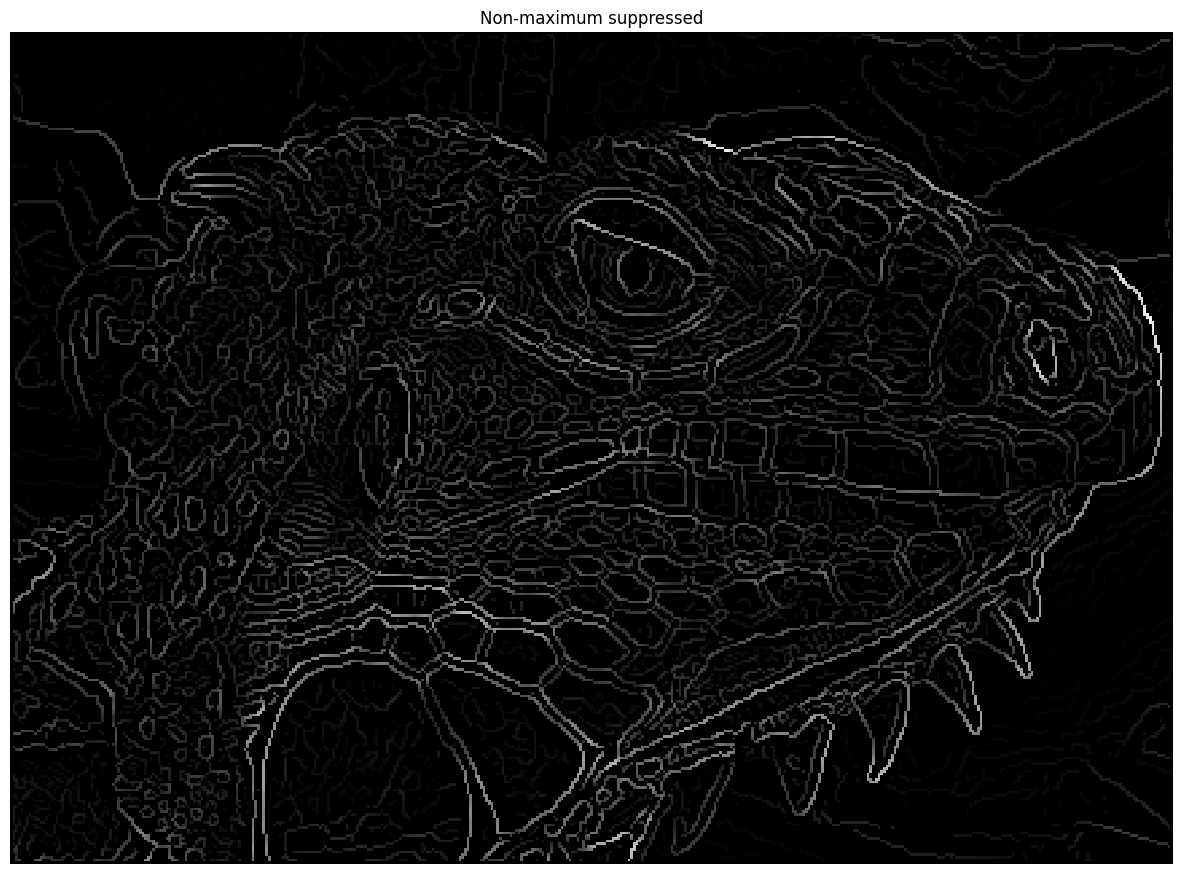

In [44]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

#### 1.2.4 Double Thresholding

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.


In [45]:
def double_thresholding(img, high, low):
    """
    Args:
        img: numpy array of shape (H, W) representing NMS edge response.
        high: high threshold(float) for strong edges.
        low: low threshold(float) for weak edges.
    Returns:
        strong_edges: Boolean array representing strong edges.
            Strong edeges are the pixels with the values greater than
            the higher threshold.
        weak_edges: Boolean array representing weak edges.
            Weak edges are the pixels with the values smaller or equal to the
            higher threshold and greater than the lower threshold.
    """

    strong_edges = np.zeros(img.shape, dtype=bool)
    weak_edges = np.zeros(img.shape, dtype=bool)

    strong_edges = img > high
    weak_edges = (img <= high) & (img > low)
    

    return strong_edges, weak_edges

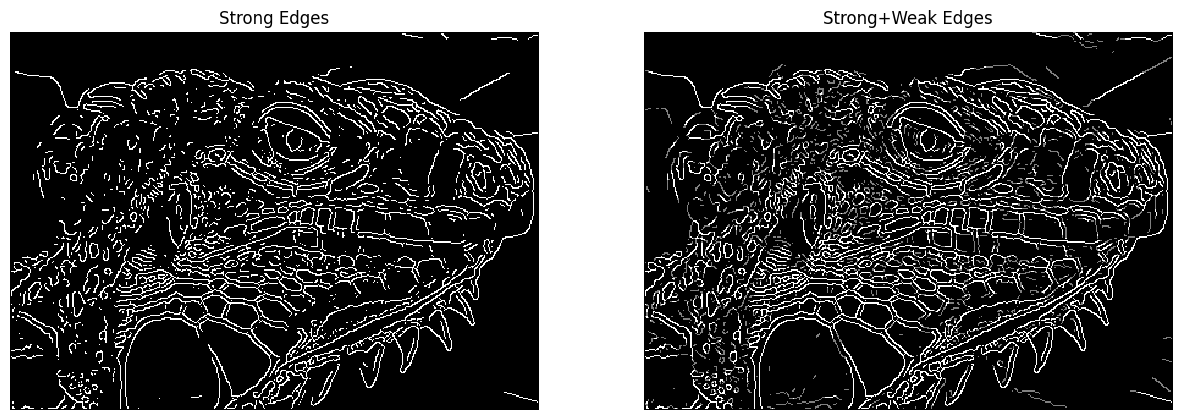

In [46]:
low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

#### 1.2.5 Edge tracking

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Weak edges are included if and only if they are connected to strong edges. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed in dependently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

In [47]:
def get_neighbors(y, x, H, W):
    """ Return indices of valid neighbors of (y, x).
    Return indices of all the valid neighbors of (y, x) in an array of
    shape (H, W). An index (i, j) of a valid neighbor should satisfy
    the following:
        1. i >= 0 and i < H
        2. j >= 0 and j < W
        3. (i, j) != (y, x)
    Args:
        y, x: location of the pixel.
        H, W: size of the image.
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)].
    """
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

In [48]:
def link_edges(strong_edges, weak_edges):
    """ Find weak edges connected to strong edges and link them.
    Iterate over each pixel in strong_edges and perform breadth first
    search across the connected pixels in weak_edges to link them.
    Here we consider a pixel (a, b) is connected to a pixel (c, d)
    if (a, b) is one of the eight neighboring pixels of (c, d).
    Args:
        strong_edges: binary image of shape (H, W).
        weak_edges: binary image of shape (H, W).
    
    Returns:
        edges: numpy boolean array of shape(H, W).
    """

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=bool)

    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    edges = np.copy(strong_edges)

    nodes_to_visit=[]
    visited_nodes = np.zeros_like(edges)
    nodes_to_visit.append((0,0))

    while len(nodes_to_visit) != 0:

            curr_i, curr_j = nodes_to_visit.pop(0)

            if visited_nodes[curr_i, curr_j] == 1:
                continue

            visited_nodes[curr_i, curr_j] = 1

            neighors = get_neighbors(curr_i, curr_j, H, W)

            for x,y in neighors:
                nodes_to_visit.append((x,y))

            adjacent_edges = False
            for x,y in neighors:
                adjacent_edges = edges[x, y] or adjacent_edges

            if weak_edges[curr_i,curr_j] and adjacent_edges:
                edges[curr_i,curr_j] = True

    return edges

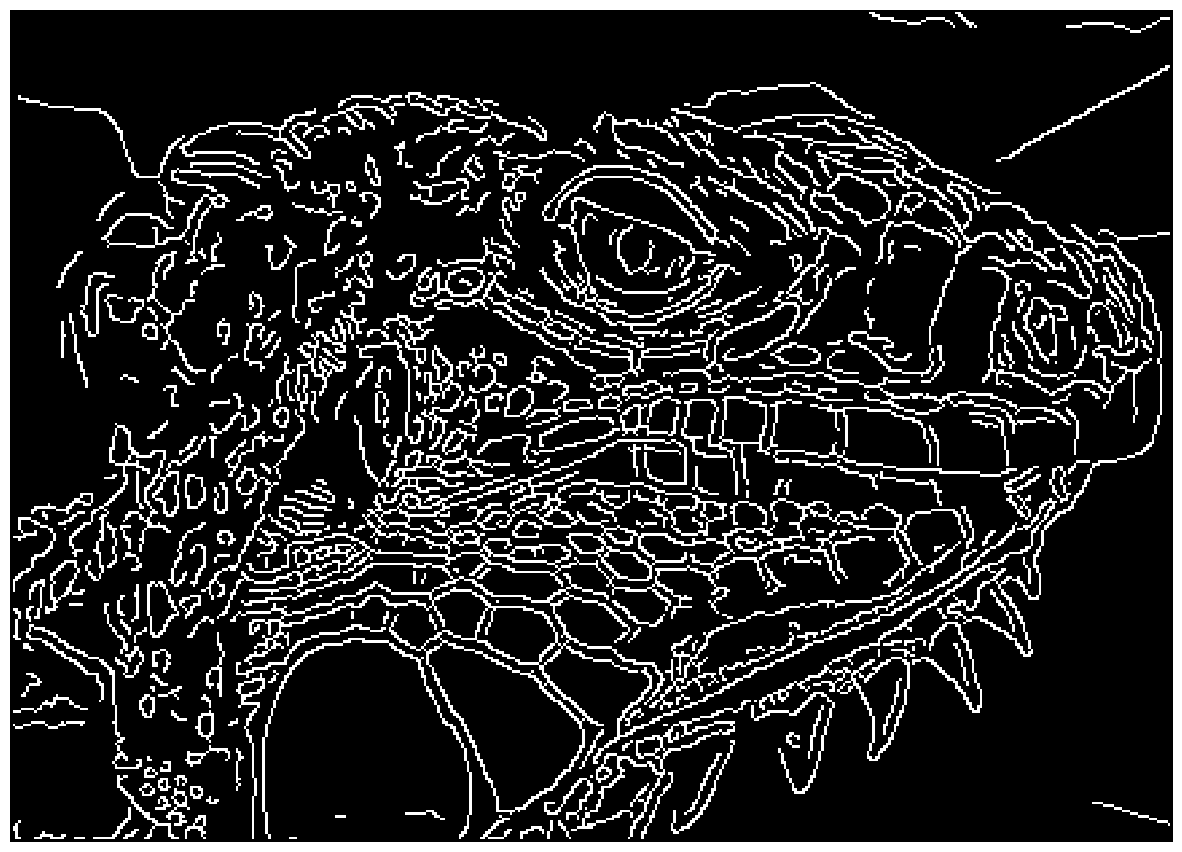

In [49]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

### 1.6 Canny edge detector

In [50]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
    """ Implement canny edge detector by calling functions above.
    Args:
        img: binary image of shape (H, W).
        kernel_size: int of size for kernel matrix.
        sigma: float for calculating kernel.
        high: high threshold for strong edges.
        low: low threashold for weak edges.
    Returns:
        edge: numpy array of shape(H, W).
    """
    H, W = img.shape
    edge = np.zeros((H, W), dtype=bool)


    img = conv(img,gaussian_kernel(kernel_size, sigma))
    G,theta = gradient(img)
    nms = non_maximum_suppression(G, theta)
    strong_edges, weak_edges = double_thresholding(nms,high,low)
    edge = link_edges(strong_edges, weak_edges)


    return edge

(310, 433)


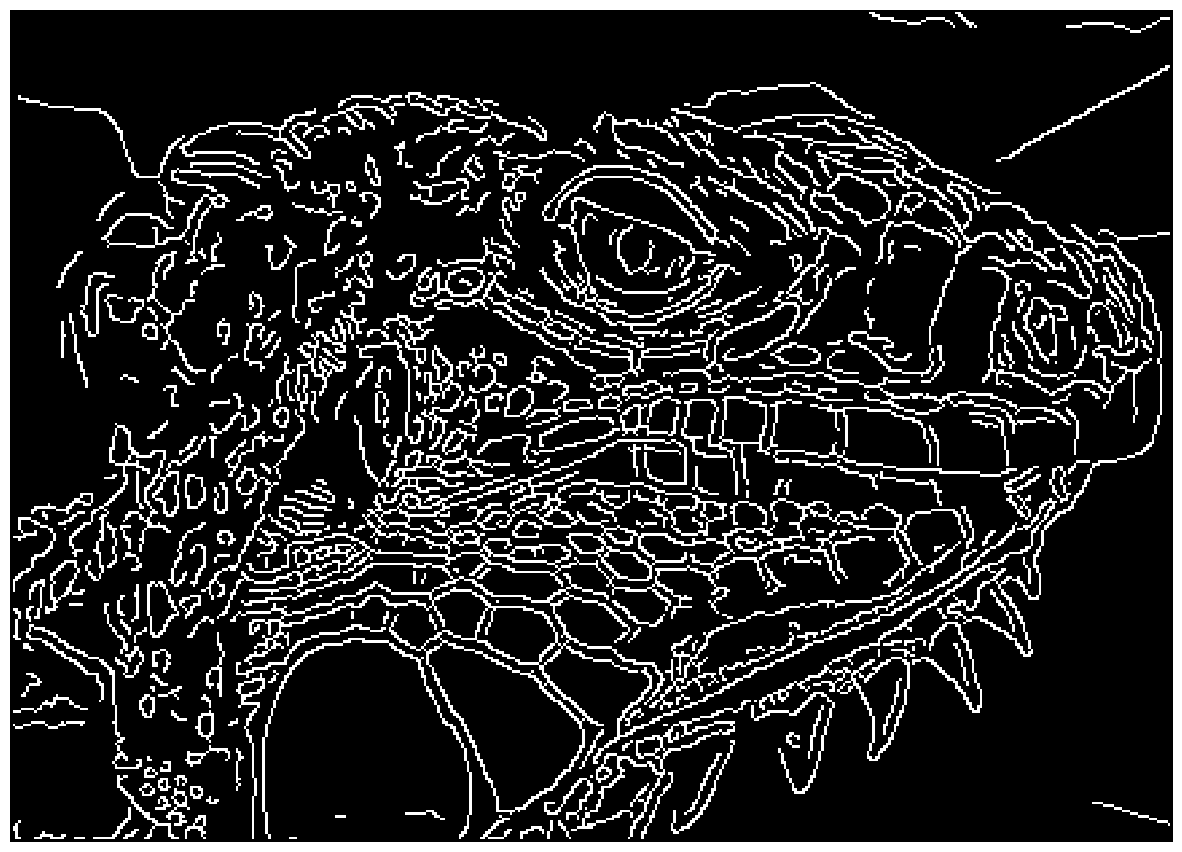

In [51]:
img = io.imread('iguana.png', as_gray=True)

edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)
print (edges.shape)
plt.imshow(edges)
plt.axis('off')
plt.show()

## Part2: Lane Detection (50 points)

In this section we will implement a simple lane detection application using Canny edge detector and Hough transform.
Here are some example images of how your final lane detector will look like.
<img src="lane1.png" width="400">
<img src="lane2.png" width="400">

The algorithm can broken down into the following steps:
1. Detect edges using the edge detector.
2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).
3. Run Hough transform to detect lanes.

### 2.1 Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Our edge detection algorithm by itself should be able to find the lanes pretty well. Run the code cell below to load the example image and detect edges from the image.

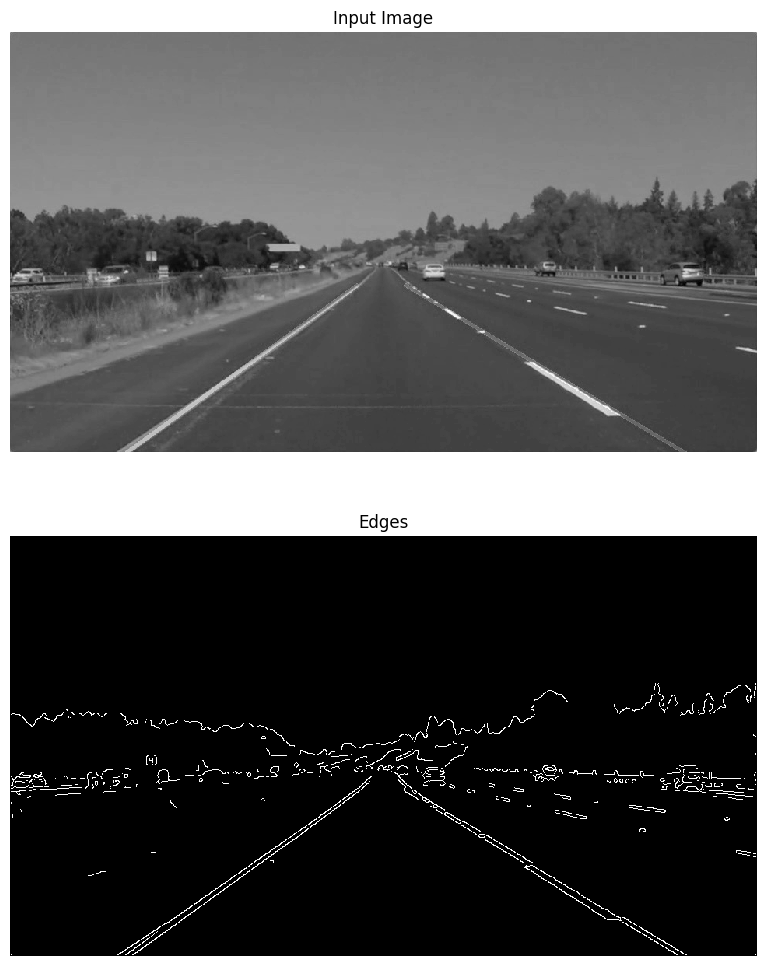

In [52]:
img = io.imread('lane1.png', as_gray=True)

edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

### 2.2 Extracting region of interest (ROI)
We can see that the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extract the edges within the region.

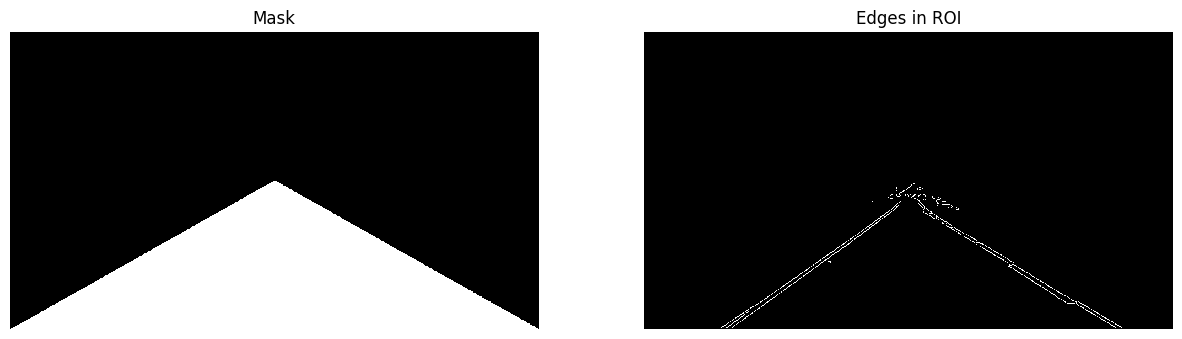

In [53]:
H, W = img.shape

mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

### 2.3 Fitting lines using Hough transform
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map everypoint in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.

*See [notes](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/HoughTrans_lines_09.pdf) on Hough transform.*

In [54]:
def hough_transform(img):
    """ Transform points in the input image into Hough space.
    Use the parameterization:
        rho = x * cos(theta) + y * sin(theta)
    to transform a point (x,y) to a sine-like function in Hough space.
    Args:
        img: binary image of shape (H, W).
        
    Returns:
        accumulator: numpy array of shape (m, n).
        rhos: numpy array of shape (m, ).
        thetas: numpy array of shape (n, ).
    """

    W, H = img.shape
    diag_len = int(np.ceil(np.sqrt(W * W + H * H)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2 + 1)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    accumulator = np.zeros((2 * diag_len + 1, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(img)
    
    for y,x in zip(ys, xs):
        for t_idx, theta in enumerate(thetas):
            rho = x*cos_t[t_idx] + y * sin_t[t_idx]
            rho_idx = int(rho +diag_len)
            accumulator[rho_idx, t_idx]+=1


    return accumulator, rhos, thetas

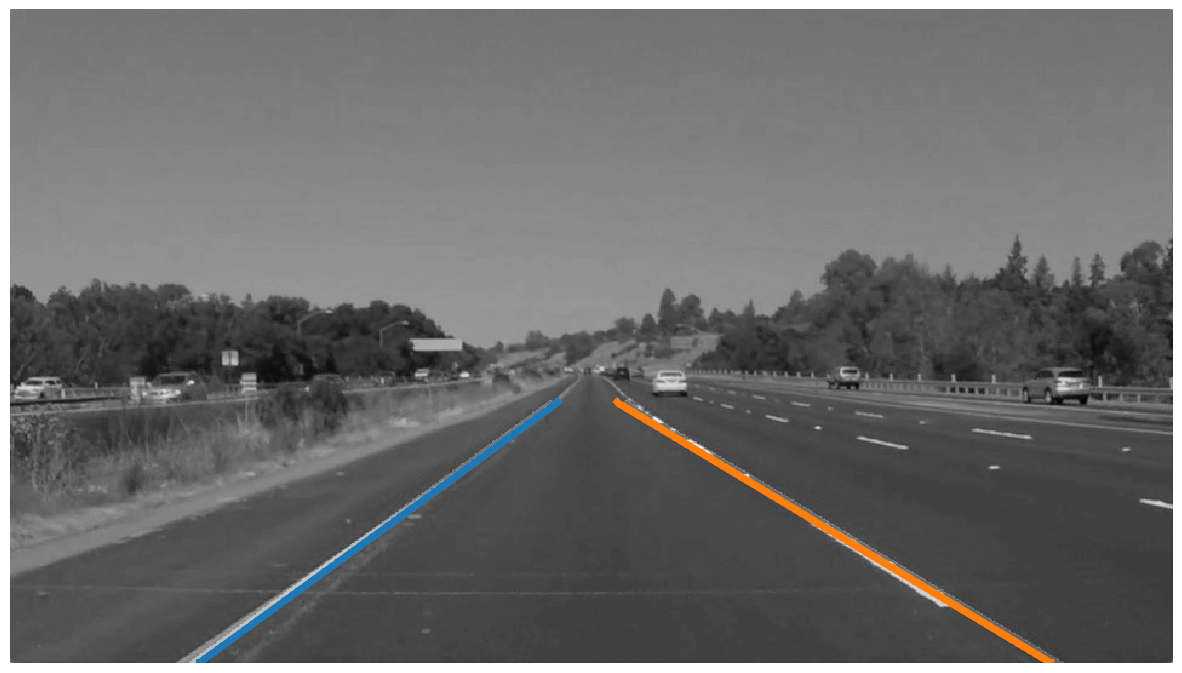

In [55]:
acc, rhos, thetas = hough_transform(roi)

xs_right = []
ys_right = []

xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 

    rho = rhos[r_idx]
    theta = thetas[t_idx]
    
    a = - (np.cos(theta)/np.sin(theta)) 
    b = (rho/np.sin(theta))

    if xs_right and xs_left:
        break
    
    if a < 0:
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else:
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()